In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import pickle

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Upload CSV files (twitter_training.csv and twitter_validation.csv) using the Colab interface

# Code for reading and processing data
# Define column names
column_names = ['Tweet_ID', 'Entity', 'Sentiment', 'Tweet_content']

# Read CSV files
train = pd.read_csv("twitter_training.csv", sep=',', names=column_names)
validation = pd.read_csv("twitter_validation.csv", sep=',', names=column_names)

In [ ]:
# Exploratory Data Analysis (EDA)
# Remove duplicate and NaN values
train.dropna(inplace=True)
train.drop_duplicates(inplace=True)

In [ ]:
# Function to remove URLs from given text
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'',text)

In [ ]:
# Function to remove emojis from given text
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F" # emojis
        u"\U0001F300-\U0001F5FF" # symbols and diagram
        u"\U0001F680-\U0001F6FF" # transport and various places
        u"\U0001F1E0-\U0001F1FF" # national flags
        u"\U00002702-\U000027B0" # dingbats
        u"\U000024C2-\U0001F251" # symbolic signs
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'',text)

In [ ]:
# Remove URL and emoji for train data
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: remove_emojis(x))
train['Tweet_content'] = train['Tweet_content'].apply(lambda x: remove_urls(x))

In [ ]:
# Remove URL and emoji for validation data
validation['Tweet_content'] = validation['Tweet_content'].apply(lambda x: remove_emojis(x))
validation['Tweet_content'] = validation['Tweet_content'].apply(lambda x:remove_urls(x))

In [ ]:
# Calculate the length of text after removing URL and emoji
train['text_lens'] = train['Tweet_content'].apply(lambda x: len(x))
validation['text_lens'] = validation['Tweet_content'].apply(lambda x: len(x))

Text(0.5, 1.0, 'Validation\xa0dataset')

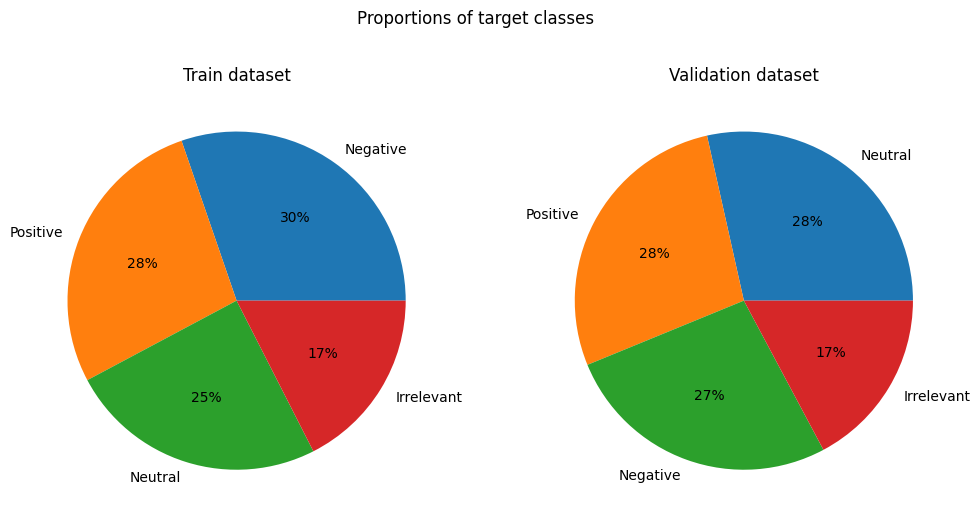

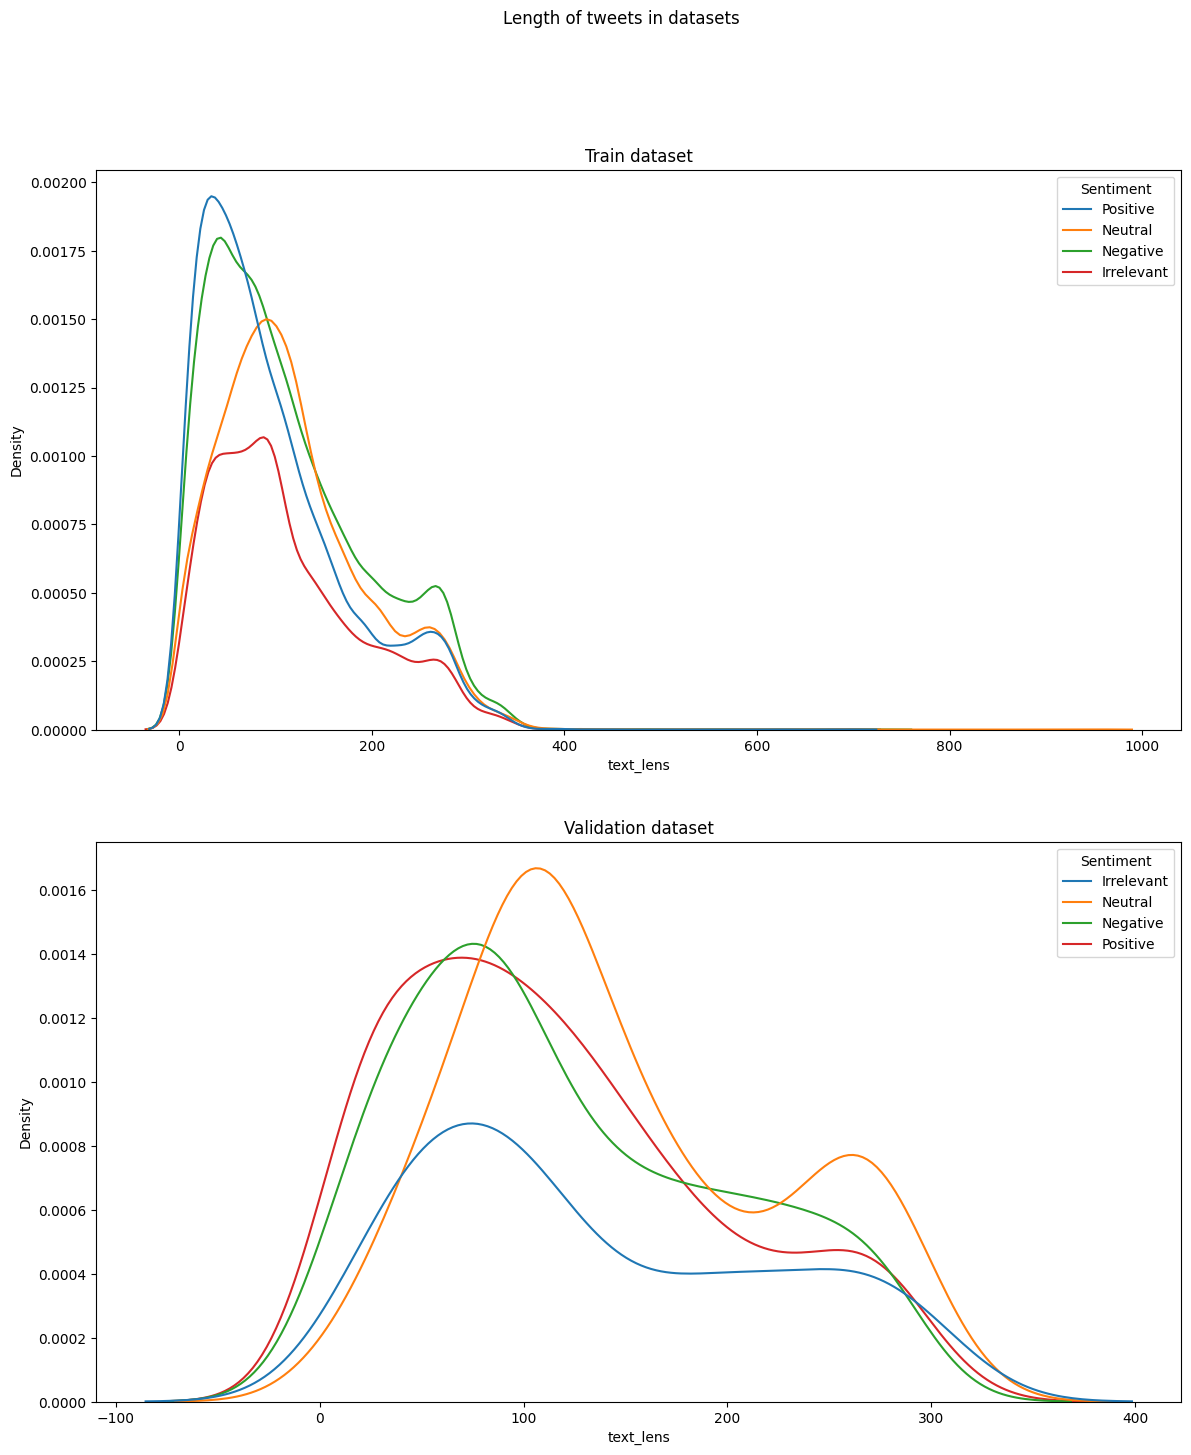

In [ ]:
# Data visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].pie(train['Sentiment'].value_counts(), labels=train['Sentiment'].value_counts().index, autopct='%.f%%')
ax[1].pie(validation['Sentiment'].value_counts(), labels=validation['Sentiment'].value_counts().index, autopct='%.f%%')
fig.suptitle("Proportions of target classes")
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

fig, ax = plt.subplots(2, 1, figsize=(14, 16))
sns.kdeplot(data=train, x='text_lens', hue='Sentiment', ax=ax[0])
sns.kdeplot(data=validation, x='text_lens', hue='Sentiment', ax=ax[1])
fig.suptitle("Length of tweets in datasets")
ax[0].set_title("Train dataset")
ax[1].set_title("Validation dataset")

In [ ]:
# Count information per category
data1 = train.groupby(by=["Entity", "Sentiment"]).count().reset_index()

Text(0.5, 1.0, 'Distribution of tweets per Branch\xa0and\xa0Type')

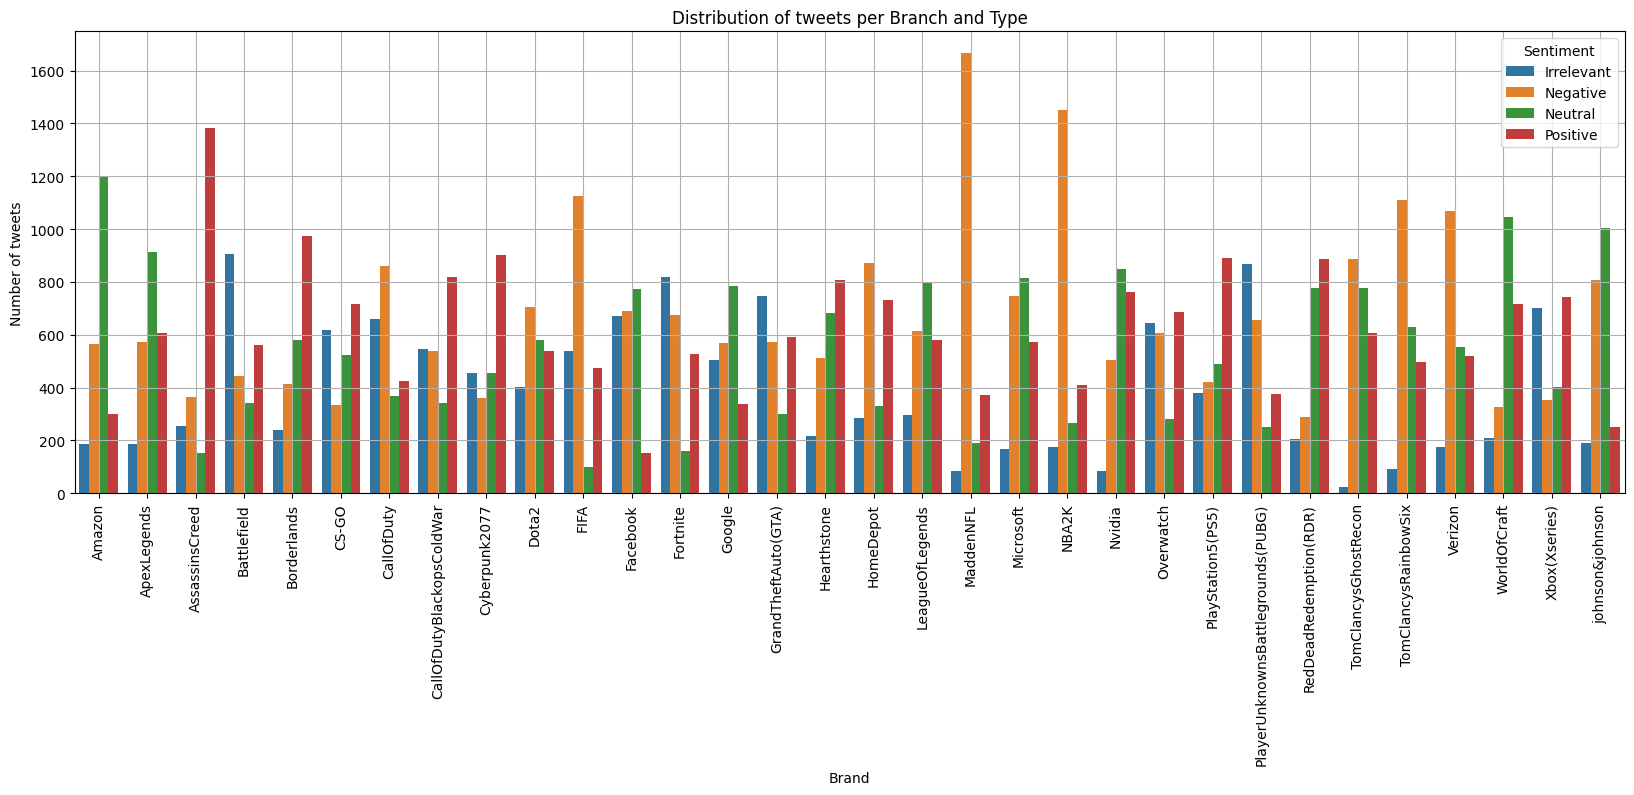

In [ ]:
# Figure of comparison per branch
plt.figure(figsize=(20, 6))
sns.barplot(data=data1, x="Entity", y="Tweet_ID", hue='Sentiment')
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type")

In [ ]:
# Data Cleaning
# Function to remove outliers
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # Interquartile range
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [ ]:
# Remove outliers
train = remove_outlier(train, 'text_lens')

In [ ]:
# Load spaCy language model
nlp = spacy.load("en_core_web_sm")

In [ ]:
# Tokenization and Lemmatization
# Preprocessing function
def preprocess(text):
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.lemma_)
    return " ".join(filtered_tokens)

In [ ]:
# Preprocess train data
train['preprocessed_text'] = train['Tweet_content'].apply(lambda x: preprocess(x))

# Preprocess validation data
validation['preprocessed_text'] = validation['Tweet_content'].apply(lambda x:preprocess(x))

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    train[['preprocessed_text']],
    train[['Sentiment']],
    test_size=0.2,
    random_state=42)

In [ ]:
# Data representation
vectorizer = TfidfVectorizer()
X_train_vect = vectorizer.fit_transform(X_train['preprocessed_text'])
X_test_vect = vectorizer.transform(X_test['preprocessed_text'])
y_train = y_train['Sentiment'].map({"Positive": 0, "Negative": 1, "Neutral": 2, "Irrelevant": 3})
y_test = y_test['Sentiment'].map({"Positive": 0, "Negative": 1, "Neutral": 2, "Irrelevant": 3})
validation_X = vectorizer.transform(validation['preprocessed_text'])
validation_y = validation['Sentiment'].map({"Positive": 0, "Negative": 1, "Neutral": 2, "Irrelevant":3})

In [ ]:
# Machine Learning
model = RandomForestClassifier()
model.fit(X_train_vect, y_train)
y_predict = model.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      3900
           1       0.92      0.92      0.92      4238
           2       0.93      0.90      0.91      3518
           3       0.97      0.85      0.91      2516

    accuracy                           0.91     14172
   macro avg       0.92      0.90      0.91     14172
weighted avg       0.91      0.91      0.91     14172



In [ ]:
# Validation test
y_predict = model.predict(validation_X)
print(classification_report(validation_y,y_predict))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       277
           1       0.92      0.96      0.94       266
           2       0.96      0.94      0.95       285
           3       0.99      0.92      0.95       172

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



In [ ]:
# Save the model and vectorizer
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer,file)

In [ ]:
# Save preprocessed data
train.to_csv("train_data.csv")
validation.to_csv('validation_data.csv')

In [ ]:
# Sample data
text = "Well that's not helping to reassure me my data is safe with @google"
text_final = vectorizer.transform([text])
predict = model.predict(text_final)
mood = {0: "Positive", 1: "Negative", 2: "Neutral", 3: "Irrelevant"}
print('Expected tone: Negative')
print('Tone of the text:', mood[list(predict)[0]])

Expected tone: Negative
Tone of the text: Negative
